In [ ]:
import os
os.environ["GOOGLE_API_KEY"] = "AIzaSyDfxDVxpCteBrQCUb8BwQST8VHUoShN"

In [309]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import ChatGoogleGenerativeAI
from sentence_transformers import SentenceTransformer
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from bs4 import BeautifulSoup

## Step 1a - Indexing (Document Ingestion)

In [310]:
from langchain_community.document_loaders import WebBaseLoader

# can extract multiple urls

url = 'https://medium.com/saarthi-ai/an-overview-of-speaker-recognition-with-sincnet-2a613a072ae5'
loader = WebBaseLoader(url)

docs = loader.load()

print(len(docs))

print(docs[0].page_content)

1
An Overview of Speaker Recognition With Sincnet | by Akash Singh | Saarthi.ai | MediumSitemapOpen in appSign upSign inMedium LogoWriteSign upSign inSaarthi.ai·Multilingual virtual AI assistants fluent in spoken languages for a complete omnichannel customer communication.An Overview of Speaker Recognition With SincnetAkash Singh8 min read·Dec 5, 2019--3ListenSharePress enter or click to view image in full sizePhoto by Thomas Le on UnsplashThis article will help you deep-dive into Speaker Recognition, and learn everything about handling audio data.We will look into SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET, an approach that converges fast on small training data.By training with only 15 seconds of audio from a single individual, we will make a Speaker identification model that can differentiate between users that it has seen while training.Speaker Recognition models capture characteristics of the voice of an individual.Here, we identify “Who is speaking?”.Two crucial parts of t

In [311]:
docs

[Document(metadata={'source': 'https://medium.com/saarthi-ai/an-overview-of-speaker-recognition-with-sincnet-2a613a072ae5', 'title': 'An Overview of Speaker Recognition With Sincnet | by Akash Singh | Saarthi.ai | Medium', 'description': 'This article will help you deep-dive into Speaker Recognition, and learn everything about handling audio data.', 'language': 'en'}, page_content='An Overview of Speaker Recognition With Sincnet | by Akash Singh | Saarthi.ai | MediumSitemapOpen in appSign upSign inMedium LogoWriteSign upSign inSaarthi.ai·Multilingual virtual AI assistants fluent in spoken languages for a complete omnichannel customer communication.An Overview of Speaker Recognition With SincnetAkash Singh8 min read·Dec 5, 2019--3ListenSharePress enter or click to view image in full sizePhoto by Thomas Le on UnsplashThis article will help you deep-dive into Speaker Recognition, and learn everything about handling audio data.We will look into SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SI

## Step 1b - Indexing (Text Splitting)

In [312]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [313]:
len(chunks)

14

In [314]:
chunks[10]

Document(metadata={'source': 'https://medium.com/saarthi-ai/an-overview-of-speaker-recognition-with-sincnet-2a613a072ae5', 'title': 'An Overview of Speaker Recognition With Sincnet | by Akash Singh | Saarthi.ai | Medium', 'description': 'This article will help you deep-dive into Speaker Recognition, and learn everything about handling audio data.', 'language': 'en'}, page_content='physical meaning.Filter AnalysisPress enter or click to view image in full sizeIn the figures above, we can easily see how CNN and Sincnet filters learn differently. This filter was learned using the Librispeech dataset (the frequency response is plotted between 0 and 4 kHz). We can see that a normal CNN learn noisy filters.Press enter or click to view image in full sizeIn the two figure figures, we can see which frequency bands are covered by CNN and Sincnet.We can see the first peak corresponds to the pitch region (the average pitch is 133 Hz for a male and 234Hz for a female).The second peak (approximative

## Step 1c & 1d - Indexing (Embedding Generation and Storing in Vector Store)

In [315]:
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_documents(chunks, embedding)

In [316]:
vector_store.index_to_docstore_id

{0: 'cc67ba64-1d98-4c71-80ab-5af8d0ebf469',
 1: '54ff1bb4-2424-47ca-a93c-ca224aacc4e4',
 2: '2d711619-1d5c-4bcc-b0ce-23ab44ba80b9',
 3: '6095afdc-efad-4d2d-ac08-fc0df594a2d6',
 4: '304f3409-fd8d-4a10-bf49-b909aef1755b',
 5: 'bc6c4d32-2f41-44c0-a621-6a8e7086123b',
 6: '4580f96a-942c-4825-b534-9143759577a0',
 7: 'ff455d94-9a9b-4adc-91c7-b74f58fe184e',
 8: 'c5cda482-867a-4959-869b-bec7be3acc76',
 9: '25945ec7-acc9-4b4f-a348-4af9127e253a',
 10: '3f8e3344-5939-4b26-b5d2-a65e27163c5b',
 11: 'c65550d8-493e-4a53-ae29-67d3f6c3f374',
 12: 'faac63ed-0459-43c8-8966-dcf3e883bfb0',
 13: '06043799-0150-4701-bee1-c08166e2b2e8'}

In [317]:
vector_store.get_by_ids(['8e59cf2f-252f-474d-8942-cc16b4bf576b'])

[]

## Step 2 - Retrieval

In [318]:
retriever = vector_store.as_retriever(search_type="similarity",search_kwargs={"k": 1})

In [319]:
retriever

VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000203AE3F0D00>, search_kwargs={'k': 1})

In [320]:
retriever.invoke('What is SincNet?')

[Document(id='6095afdc-efad-4d2d-ac08-fc0df594a2d6', metadata={'source': 'https://medium.com/saarthi-ai/an-overview-of-speaker-recognition-with-sincnet-2a613a072ae5', 'title': 'An Overview of Speaker Recognition With Sincnet | by Akash Singh | Saarthi.ai | Medium', 'description': 'This article will help you deep-dive into Speaker Recognition, and learn everything about handling audio data.', 'language': 'en'}, page_content='region. Thus, CNN should be designed in a way that it can capture meaningful features.According to the paper published on Sincnet, the first Convolution layer of the current waveform CNN is the most important as it gets high dimensional inputs. It also gets affected by the Vanishing Gradient.To overcome this in Sincnet, we have parametrized sinc functions to implement band-pass filters.The low and high cutoff frequencies are the only parameters of the filter learned from data. This solution still offers considerable flexibility, but forces the network to focus on hi

## Step 3 - Augmentation

In [321]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.2)

In [322]:
prompt = PromptTemplate(
    template="""
      You are a helpful assistant.
      Answer ONLY from the provided transcript context.
      If the context is insufficient, just say you don't know.

      {context}
      Question: {question}
    """,
    input_variables = ['context', 'question']
)

In [323]:
question          = "is the topic of sincnet discussed in this video? if yes then what was discussed"
retrieved_docs    = retriever.invoke(question)

In [324]:
retrieved_docs

[Document(id='6095afdc-efad-4d2d-ac08-fc0df594a2d6', metadata={'source': 'https://medium.com/saarthi-ai/an-overview-of-speaker-recognition-with-sincnet-2a613a072ae5', 'title': 'An Overview of Speaker Recognition With Sincnet | by Akash Singh | Saarthi.ai | Medium', 'description': 'This article will help you deep-dive into Speaker Recognition, and learn everything about handling audio data.', 'language': 'en'}, page_content='region. Thus, CNN should be designed in a way that it can capture meaningful features.According to the paper published on Sincnet, the first Convolution layer of the current waveform CNN is the most important as it gets high dimensional inputs. It also gets affected by the Vanishing Gradient.To overcome this in Sincnet, we have parametrized sinc functions to implement band-pass filters.The low and high cutoff frequencies are the only parameters of the filter learned from data. This solution still offers considerable flexibility, but forces the network to focus on hi

In [325]:
context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
context_text

'region. Thus, CNN should be designed in a way that it can capture meaningful features.According to the paper published on Sincnet, the first Convolution layer of the current waveform CNN is the most important as it gets high dimensional inputs. It also gets affected by the Vanishing Gradient.To overcome this in Sincnet, we have parametrized sinc functions to implement band-pass filters.The low and high cutoff frequencies are the only parameters of the filter learned from data. This solution still offers considerable flexibility, but forces the network to focus on high-level tunable parameters with a broad impact on the shape and bandwidth of the resulting filter.In the next section, we will see how Sincnet is designed to work efficiently.Breaking down the Architecture of SincnetWe take a standard CNN which performs time-domain convolutions(Convolution in time domain equals multiplication in the frequency domain) between input waveform and some Finite Impulse Response (FIR) filters as'

In [326]:
final_prompt = prompt.invoke({"context": context_text, "question": question})

In [327]:
final_prompt

StringPromptValue(text="\n      You are a helpful assistant.\n      Answer ONLY from the provided transcript context.\n      If the context is insufficient, just say you don't know.\n\n      region. Thus, CNN should be designed in a way that it can capture meaningful features.According to the paper published on Sincnet, the first Convolution layer of the current waveform CNN is the most important as it gets high dimensional inputs. It also gets affected by the Vanishing Gradient.To overcome this in Sincnet, we have parametrized sinc functions to implement band-pass filters.The low and high cutoff frequencies are the only parameters of the filter learned from data. This solution still offers considerable flexibility, but forces the network to focus on high-level tunable parameters with a broad impact on the shape and bandwidth of the resulting filter.In the next section, we will see how Sincnet is designed to work efficiently.Breaking down the Architecture of SincnetWe take a standard C

## Step 4 - Generation

In [328]:
answer = llm.invoke(final_prompt)
print(answer.content)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 7
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing det

ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 3
}
]

## Building a Chain

In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

In [ ]:
def format_docs(retrieved_docs):
  context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
  return context_text

In [ ]:
parallel_chain = RunnableParallel({
    'context' : retriever | RunnableLambda(format_docs),
    'question' : RunnablePassthrough()
})

In [ ]:
parallel_chain.invoke('what is sincnet?')

{'context': 'region. Thus, CNN should be designed in a way that it can capture meaningful features.According to the paper published on Sincnet, the first Convolution layer of the current waveform CNN is the most important as it gets high dimensional inputs. It also gets affected by the Vanishing Gradient.To overcome this in Sincnet, we have parametrized sinc functions to implement band-pass filters.The low and high cutoff frequencies are the only parameters of the filter learned from data. This solution still offers considerable flexibility, but forces the network to focus on high-level tunable parameters with a broad impact on the shape and bandwidth of the resulting filter.In the next section, we will see how Sincnet is designed to work efficiently.Breaking down the Architecture of SincnetWe take a standard CNN which performs time-domain convolutions(Convolution in time domain equals multiplication in the frequency domain) between input waveform and some Finite Impulse Response (FIR)

In [ ]:
parser = StrOutputParser()

In [ ]:
main_chain = parallel_chain | prompt | llm | parser

In [ ]:
main_chain.invoke('what is sincnet?')

"Based on the provided text, SincNet is a type of CNN (Convolutional Neural Network) that uses parametrized sinc functions to implement band-pass filters in its first convolutional layer.  This addresses the vanishing gradient problem and allows the network to focus on high-level tunable parameters that broadly impact the filter's shape and bandwidth."

# C-RAG

In [ ]:
import os
os.environ["TAVILY_API_KEY"] = "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"

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import PyPDFLoader
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
from typing_extensions import TypedDict
from langchain.schema import Document
from langgraph.graph import END, StateGraph, START

In [ ]:
pdf = r"C:\Users\DELL\Desktop\youtube chatbot\final_main.pdf"

In [ ]:
loader = PyPDFLoader(pdf)
docs = loader.load()  # already a flat list of Documents

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=100
)
docs_list = text_splitter.split_documents(docs)


In [ ]:
texts = [doc.page_content for doc in docs_list]

In [ ]:
docs

[Document(metadata={'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-07-10T06:48:12+00:00', 'source': 'C:\\Users\\DELL\\Desktop\\youtube chatbot\\final_main.pdf', 'total_pages': 29, 'page': 0, 'page_label': '1'}, page_content='Gandhinagar  University  Admission  Guide   \nIntroduction   \nThis  document  provides  comprehensive  information  on  the  academic  programs  \noffered\n \nby\n \nGandhinagar\n \nUniversity\n \nand\n \nthe\n \nGandhinagar\n \nInstitute\n \nof\n \nSkill\n \nDevelopment\n \n(GISD).\n \nIt\n \nincludes\n \ndetails\n \non\n \nprogram\n \nduration,\n \neligibility,\n \nadmission\n \nprocess,\n \ntuition\n \nfees,\n \nand\n \nintake\n \ncapacities.\n \nFor\n \nthe\n \nmost\n \ncurrent\n \ninformation,\n \nplease\n \nvisit\n \nthe\n \nofficial\n \nuniversity\n \nwebsite\n \nor\n \ncontact\n \nthe\n \nadmission\n \noffice.\n \n \n1  Engineering  Programs   \n1.1  Bachelor  of  Technology  (B.Tech)   •  Duration :  4  Years   \n•  Eligi

In [ ]:
splits = text_splitter.split_documents(docs)
vector_store = FAISS.from_documents(splits, embedding)
retriever = vector_store.as_retriever()

In [ ]:
vector_store.index_to_docstore_id

{0: '0575dc94-6375-4779-a0b4-1904fdbf29b1',
 1: 'a379f700-09ff-438d-9519-b70de0cee9b7',
 2: '6ee5dbe2-a494-45a8-9add-b165021091d1',
 3: 'bf8b5b2f-310f-4d75-85af-a0d24eb534f0',
 4: '4698a2cc-2b4f-4a5a-8cb9-624c5e73e8aa',
 5: 'ebbbe36a-8610-409b-b7d7-1d449563a030',
 6: '3040f3c3-6174-4bd3-a8e4-00aab6284335',
 7: '99323fbd-faa9-42b8-ba97-295cc5dc5a36',
 8: 'fb9a3fcc-4ba0-4b83-a510-9b254976d113',
 9: '3651e60f-77f1-439d-99a3-4c23de6e2d27',
 10: 'ece0dace-9916-439a-bbd5-c7d07de8a96b',
 11: '3d9f734d-ef71-4cab-8155-e27e44c92141',
 12: '75d159ee-2210-4e8a-8f64-4174cd9ad04d',
 13: '9ec7bfef-3e77-416f-8bcd-a49624bfd90c',
 14: 'fae2aff1-3405-4bf0-8326-096b0c81777a',
 15: 'dca091bc-e7d9-4ce3-9bd3-55ebf1488896',
 16: '8dc1afe8-11f4-4ba1-ae36-3f2bc3107316',
 17: '6b054248-8716-492c-acb5-fc4379763b93',
 18: '07e0deb7-9754-4817-be6d-2760e80ba224',
 19: '34557918-4297-48a1-9fb7-53c36b52abf3',
 20: 'd8e8f4f2-205a-414a-bb28-f9a682bbb06d',
 21: '6a8b2c63-af9d-4608-bc0c-66ca4b57aaf8',
 22: 'b6323e2a-2352-

In [ ]:
vector_store.get_by_ids(['00b91e18-b557-45fe-8728-48fa917e4d62'])

[]

In [329]:
rag_prompt = hub.pull("rlm/rag-prompt")

# Chain
rag_chain = prompt | llm | StrOutputParser()
print(rag_prompt.messages[0].prompt.template)

c:\Users\DELL\anaconda3\envs\langchain\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [330]:
class Evaluator(BaseModel):
    """ Classify retrieved documents based on its relevance to the question."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no' "
    )


evaluator_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
output_llm_evaluator = evaluator_llm.with_structured_output(Evaluator)

system = """You are tasked with evaluating the relevance of a retrieved document to a user's question. \n If the document contains keywords or semantic content related to the question, mark it as relevant. \n Output a binary score: 'yes' if the document is relevant, or 'no' if it is not"""
retrieval_evaluator_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \\n\\n {document} \\n\\n User question: {question}"),
    ]
)

retrieval_grader = retrieval_evaluator_prompt | output_llm_evaluator

In [331]:
question_rewriter_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

system = """You are a question rewriter who improves input questions to make them more effective for web search. \n Analyze the question and focus on the underlying semantic intent to craft a better version."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human", "Here is the initial question: {question} \n\n Formulate an improved question"),
    ]
)
question_rewriter = re_write_prompt | question_rewriter_llm | StrOutputParser()

In [332]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=1)

In [333]:
class GraphState(TypedDict):
    """State of the graph."""
    question: str
    generation: str
    web_search: str
    documents: List[Document]

In [334]:
def retrieve(state):
    question = state["question"]
    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [336]:
def generate(state):
    question = state["question"]
    documents = state["documents"]
    # Generation
    generation = rag_chain.invoke({"context":documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [337]:
def evaluate_documents(state):
    question = state["question"]
    documents_all = state["documents"]

    docs_filtered = []
    web_search = "No"

    for d in documents_all:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            docs_filtered.append(d)
        else:
            continue

    if len(docs_filtered) / len(documents_all) <= 0.7:
        web_search = "Yes"
    return {"documents": docs_filtered, "question": question, "web_search": web_search}


In [338]:
def transform_query(state):
    question = state["question"]
    documents_all = state["documents"]
    # Re-write question
    transform_question = question_rewriter.invoke({"question":question})
    return {"documents": documents_all, "question": transform_question, "web_search": "No"}

In [339]:
def web_search(state):
    question = state["question"]
    documents_all = state["documents"]
    # # Web search
    # docs = web_search_tool.invoke({"query": question})
    
    # #Fetch results from web
    # web_results = "\n".join([d["content"] for d in docs])
    # web_document = Document(page_content=web_results)
        
    #     # Append the results from the web to the documents
    # if documents_all is None:
    #     documents_all = []
    # documents_all.append(web_document)

    # #append the results from the web to the documents
    # documents_all.append(web_results)
    # return {"documents": documents_all, "question": question}

    try:
        docs = web_search_tool.invoke({"query": question})
        print(f"Web search results: {docs}")

        #create individual Document objects for each result
        web_documents = []
        for i, doc in enumerate(docs):
            # Ensure we extract only string content
            content = ""
            if isinstance(doc,dict):
                content = doc.get("content", "")
            else:
                content = str(doc)

            # create a proper Document object with string
            if content.strip():
                web_doc = Document(
                    page_content=content,
                    metadata={"source": f"web_search_result_{i+1}"}
                )
                web_documents.append(web_doc)

        if documents_all is None:
            documents_all = []

        documents_all.extend(web_documents)
        print(f"Documents after web search: {documents_all}")

    except Exception as e:
        print(f"Error during web search: {e}")
        if documents_all is None:
            documents_all = []

    return {"documents": documents_all, "question": question}

In [340]:
def decide_next_step(state):
    web_search = state["web_search"]
    if web_search == "Yes":
        return "transform_query"
    else:
        return "generate"

![Alt Text](c-rag.png)

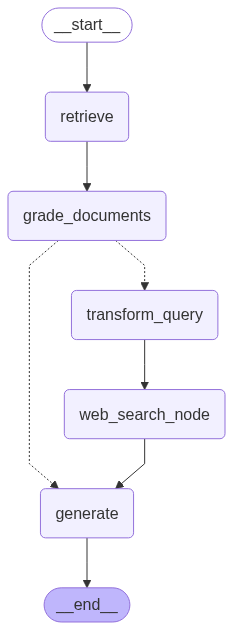

In [341]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", evaluate_documents) # evaluate documents
workflow.add_node("generate", generate) # generate answer
workflow.add_node("transform_query", transform_query) # transform_query
workflow.add_node("web_search_node", web_search) # web search

# Adding the Edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_next_step,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

#Compile
workflow.compile()

In [342]:
app = workflow.compile()

In [343]:
from pprint import pprint
# inputs = {"question": "What is the difference between Flat white and cappuccino?"}
# for output in app.stream(inputs):
#     for key, value in output.items():
#         # Node
#         pprint(f"Node '{key}':")
#         # Optional: print full state at each node
#         pprint(value, indent=2, width=80, depth=None)
#     pprint("\\n---\\n")
# # Final generation
# pprint(value["generation"])
def run_rag_workflow(question: str):
    """Run the RAG workflow with the given question."""
    inputs = {"question": question}
    
    try:
        for output in app.stream(inputs):
            for key, value in output.items():
                print(f"Node '{key}':")
                # Print relevant parts of the state
                if key == "retrieve":
                    print(f"  Retrieved {len(value.get('documents', []))} documents")
                elif key == "grade_documents":
                    print(f"  Filtered to {len(value.get('documents', []))} relevant documents")
                    print(f"  Web search needed: {value.get('web_search', 'No')}")
                elif key == "transform_query":
                    print(f"  Transformed question: {value.get('question', '')}")
                elif key == "web_search_node":
                    print(f"  Added web search results, total documents: {len(value.get('documents', []))}")
                elif key == "generate":
                    print(f"  Generated response")
                print("---")
        
        # Return the final generation
        return value.get("generation", "No generation found")
        
    except Exception as e:
        print(f"Error in workflow execution: {e}")
        return None

In [344]:
if __name__ == "__main__":
    question = "What is the difference between Flat white and cappuccino?"
    result = run_rag_workflow(question)
    
    if result:
        print("\nFinal Answer:")
        print(result)

Node 'retrieve':
  Retrieved 1 documents
---
Node 'grade_documents':
  Filtered to 0 relevant documents
  Web search needed: Yes
---


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 32
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing de

Node 'transform_query':
  Transformed question: Flat white vs. cappuccino: What are the key differences in milk texture, coffee strength, and presentation?
---
Web search results: [{'title': 'Flat White vs Cappuccino: The Differences | Nescafé | UK & IE', 'url': 'https://www.nescafe.com/gb/coffee-culture/knowledge/flat-white-vs-cappuccino', 'content': 'A flat white is a much creamier drink thanks to the amount of steamed milk, and also contains a higher amount of caffeine, as it contains two shots of espresso. Whereas the cappuccino is only made with one shot of espresso, with steamed milk, and then topped with milk foam. This gives the cappuccino a more distinct flavour. [...] However, the milk that is in each drink is prepared differently from each other. This affects the texture and creaminess of the drink. Flat whites are made with a thin layer of milk foam but contain most of their steamed milk within the drink. Whereas Cappuccinos, focus primarily on foamed milk on top of the dri

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 22
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing de

Error in workflow execution: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 17
}
]
